In [66]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/friends2/friends_test2.json
/kaggle/input/friends2/friends_dev2.json
/kaggle/input/friends2/friends_train2.json
/kaggle/input/dfc615e/en_data.csv
/kaggle/input/dfc615e/en_sample.csv


In [67]:
df_last = pd.read_csv("/kaggle/input/dfc615e/en_data.csv", sep=",", encoding="ms949")
sample = pd.read_csv("/kaggle/input/dfc615e/en_sample.csv", sep=",", encoding="ms949")
dev_file = open('/kaggle/input/friends2/friends_test2.json', encoding="utf-8")
dev_data = json.load(dev_file)
train_file = open('/kaggle/input/friends2/friends_train2.json', encoding="utf-8")
train_data = json.load(train_file)
test_file = open('/kaggle/input/friends2/friends_dev2.json', encoding="utf-8")
test_data = json.load(test_file)

In [68]:
df_last.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


In [69]:
df_dev = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_train = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])
df_test = pd.DataFrame(columns=['annotation', 'emotion', 'speaker', 'utterance'])

for i in range(len(dev_data)):
    df_dev = pd.concat([df_dev, pd.DataFrame(dev_data[i])])

for i in range(len(train_data)):
    df_train = pd.concat([df_train, pd.DataFrame(train_data[i])])

for i in range(len(test_data)):
    df_test = pd.concat([df_test, pd.DataFrame(test_data[i])])

df_dev = df_dev.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [70]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 랭커스터 스태머의 사용
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

# Lemmatization 음소표기법
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [71]:
stops = set(stopwords.words('english'))

In [72]:
df_dev['words'] = ''
df_train['words'] = ''
df_test['words'] = ''
df_last['words'] = ''

len(df_dev), len(df_train), len(df_test), len(df_last)

(2764, 10561, 1178, 3296)

In [73]:
def comment_to_words(data):
    # 1. 영어가 아닌 문자는 공백으로 변환
    data = re.sub('[^a-zA-Z]', ' ', data)
    
    # 2. 소문자로 변환
    lowerdata = data.lower()
    
    # 3. 문자열로 변환
    words = lowerdata.split()
    
    # 4. 불용어 제거
    words = [w for w in words if not w in stops]
    
    # 5. 어간추출
    stemming_words = [stemmer.stem(w) for w in words]
    
    # 7. 공백으로 구분된 문자열로 결합하여 결과를 반환
    words = ' '.join(stemming_words)
    return words

In [74]:
# 개발 데이터셋 전처리
for i in range(0, len(df_dev)):
    df_dev.loc[i, 'words'] = comment_to_words(df_dev.loc[i, 'utterance'])

# 훈련 데이터셋 전처리
for i in range(0, len(df_train)):
    df_train.loc[i, 'words'] = comment_to_words(df_train.loc[i, 'utterance'])    

# 테스트 데이터셋 전처리
for i in range(0, len(df_test)):
    df_test.loc[i, 'words'] = comment_to_words(df_test.loc[i, 'utterance'])    

# LAST 데이터셋 전처리
for i in range(0, len(df_test)):
    df_last.loc[i, 'words'] = comment_to_words(df_last.loc[i, 'utterance'])    

In [75]:
y_info = [['neutral', 0],
          ['surprise', 1],
          ['non-neutral', 2],
          ['joy', 3],
          ['sadness', 4],
          ['anger', 5],
          ['disgust', 6]]

y_info = [['neutral', 'neutral'],
          ['surprise', 'surprise'],
          ['non-neutral', 'non-neutral'],
          ['joy', 'joy'],
          ['sadness', 'sadness'],
          ['anger', 'anger'],
          ['disgust', 'disgust']]
        

In [76]:
df_y = pd.DataFrame(y_info, columns=['emotion', 'Y'])

In [77]:
df_dev = pd.merge(df_dev, df_y, on=['emotion'])
df_train = pd.merge(df_train, df_y, on=['emotion'])
df_test = pd.merge(df_test, df_y, on=['emotion'])

In [78]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras import backend as K
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

In [80]:
tk = Tokenizer(df_train['words'], lower=True, split=" ")
tk.fit_on_texts(df_train['words'])

1. CountVectorizer는 이러한 작업을 하기 위한 다음과 같은 인수를 가질 수 있다.¶
 - stop_words : 문자열 {‘english’}, 리스트 또는 None (디폴트)
    * stop words 목록.‘english’이면 영어용 스탑 워드 사용.
 - analyzer : 문자열 {‘word’, ‘char’, ‘char_wb’} 또는 함수
    * 단어 n-그램, 문자 n-그램, 단어 내의 문자 n-그램
 - token_pattern : string
    * 토큰 정의용 정규 표현식
 - tokenizer : 함수 또는 None (디폴트)
    * 토큰 생성 함수 .
 - ngram_range : (min_n, max_n) 튜플
    * n-그램 범위
 - max_df : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    * 단어장에 포함되기 위한 최대 빈도
 - min_df : 정수 또는 [0.0, 1.0] 사이의 실수. 디폴트 1
    * 단어장에 포함되기 위한 최소 빈도

In [81]:

# 튜토리얼과 다르게 파라메터 값을 수정
# 파라메터 값만 수정해도 캐글 스코어 차이가 많이 남
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 3),
                             max_features = 20000
                            )

In [82]:
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))


In [83]:
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [84]:
#train_data_features = pipeline.fit_transform(df_train['words'].values)
train_data_features = pipeline.fit_transform(df_train['utterance'].values)
train_data_features.shape

(10376, 14587)

In [85]:
vocab = vectorizer.get_feature_names()

# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[ 5  7 10 ...  2  3  4]] 00


,00,000,10,100,13,15,16,17,17 minutes,18,...,your your,yours,yours and,yourself,yourself up,yourself you,yuh,yuh huh,zelner,zoo
0,5,7,10,2,3,4,3,4,2,2,...,3,12,2,23,2,2,2,2,3,4


# 랜덤포레스트 학습

In [86]:
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state=0)
forest

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)

In [87]:
df_train.head()

,annotation,emotion,speaker,utterance,words,Y
0,4100000,neutral,Chandler,also I was the point person on my companys tr...,also point person compani transit kl gr system,neutral
1,5000000,neutral,The Interviewer,You mustve had your hands full.,must hand full,neutral
2,5000000,neutral,Chandler,That I did. That I did.,,neutral
3,5000000,neutral,The Interviewer,So lets talk a little bit about your duties.,let talk littl bit duti,neutral
4,5000000,neutral,The Interviewer,"Now youll be heading a whole division, so you...",head whole divis lot duti,neutral


In [88]:
%%time
traindata = pd.DataFrame(train_data_features.toarray(), columns=vocab)
forest.fit(traindata.values, df_train['Y'])

CPU times: user 2min 54s, sys: 1.34 s, total: 2min 56s
Wall time: 47.9 s


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0)

In [89]:
%time 
score = np.mean(cross_val_score(forest,
                                train_data_features,
                                df_train['Y'],
                                cv=10))
score

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs


0.5019275254875948

In [90]:
trainpredict = forest.predict(train_data_features.toarray())
trainpredict[-10:]

array(['disgust', 'disgust', 'disgust', 'disgust', 'disgust', 'disgust',
       'disgust', 'disgust', 'disgust', 'disgust'], dtype=object)

In [91]:
#test_data_features = pipeline.transform(df_test['words'].values)
test_data_features = pipeline.transform(df_test['utterance'].values)
test_data_features = test_data_features.toarray()

test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [92]:
%time 

score = np.mean(cross_val_score(forest,
                                test_data_features,
                                df_test['Y'],
                                cv=10))
score

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


0.42909229595728454

In [93]:
testdata = pd.DataFrame(test_data_features, columns=vocab)
testpredict = forest.predict(testdata.values)

In [94]:
pd.Series(testpredict).value_counts()

neutral        894
surprise       113
non-neutral     70
joy             45
anger           16
sadness         10
disgust          1
dtype: int64

In [95]:
df_test['Y'].value_counts()

neutral        491
non-neutral    214
surprise       151
joy            123
anger           85
sadness         62
disgust         23
Name: Y, dtype: int64

In [96]:
df_test.head()

,annotation,emotion,speaker,utterance,words,Y
0,0002120,non-neutral,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",oh god lost total lost,non-neutral
1,2200010,non-neutral,Phoebe,"I-Im sorry, but the moment I touch him, I jus...",sorri moment touch wanna throw old oath take n...,non-neutral
2,1000211,non-neutral,Ross,"Ah Ah Get out of here! Uh, meeting someone? ...",ah ah get uh meet someon brush marion view evolut,non-neutral
3,1021100,non-neutral,Ross,The point is I...,point,non-neutral
4,0220100,non-neutral,Ross,"It, it's too late, I'm with somebody else, I'm...",late somebodi els happi,non-neutral


캐글데이터

In [97]:
%%time
last_data_features = pipeline.transform(df_last['utterance'].values)
last_data_features = last_data_features.toarray()


CPU times: user 131 ms, sys: 40 ms, total: 171 ms
Wall time: 169 ms


In [98]:
%%time
lastdata = pd.DataFrame(last_data_features, columns=vocab)
lastpredict = forest.predict(lastdata.values)

CPU times: user 924 ms, sys: 100 ms, total: 1.02 s
Wall time: 527 ms


In [99]:
sample['Predicted'] = lastpredict

In [100]:
sample['Predicted'].value_counts()

neutral        2607
surprise        341
non-neutral     160
joy             127
sadness          28
anger            25
disgust           8
Name: Predicted, dtype: int64

### 단어 벡터화

In [101]:
# vectorizer = CountVectorizer(analyzer = 'word', 
#                              tokenizer = None,
#                              preprocessor = None, 
#                              stop_words = stops, 
#                              min_df = 4, # 토큰이 나타날 최소 문서 개수
#                              ngram_range=(1, 4),
#                              max_features = 10000
#                             )

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = nltk.word_tokenize,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 10000
                            )
vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(1, 4),
                             max_features = 10000
                            )

In [102]:
%%time

pipeline = Pipeline([
    ('vect', vectorizer),
])

train_data_features = pipeline.fit_transform(df_train['utterance'].values)
vectorizer._validate_vocabulary()
vocab = vectorizer.get_feature_names()

# 벡터화 된 피처를 확인해 봄
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(n_estimators = 25, n_jobs = -1, random_state=1)
data = pd.DataFrame(train_data_features.toarray(), columns=vocab)

# 데이터 학습
print("데이터 학습")
forest.fit(data.values, df_train['Y'])

score = np.mean(cross_val_score(forest,
                                train_data_features,
                                df_train['Y'],
                                cv=10))

# 정확도 출력 
print("정확도 학습")
score

[[ 5  7 10 ...  2  3  4]] 00
데이터 학습
정확도 학습
CPU times: user 1min 5s, sys: 688 ms, total: 1min 6s
Wall time: 45.8 s


0.500867981040611

테스트

In [103]:
%%time
test_data_features = pipeline.transform(df_test['utterance'].values)
test_data_features = test_data_features.toarray()
test = pd.DataFrame(test_data_features, columns=vocab)
testpredict = forest.predict(test.values)
score = np.mean(cross_val_score(forest,
                                test_data_features,
                                df_test['Y'],
                                cv=10))
score

CPU times: user 1.77 s, sys: 665 ms, total: 2.43 s
Wall time: 11.6 s


0.4220747520976354

In [104]:
pd.Series(testpredict).value_counts()

neutral        874
surprise       111
non-neutral     90
joy             49
anger           13
sadness         10
disgust          2
dtype: int64

In [105]:
df_test['Y'].value_counts()

neutral        491
non-neutral    214
surprise       151
joy            123
anger           85
sadness         62
disgust         23
Name: Y, dtype: int64

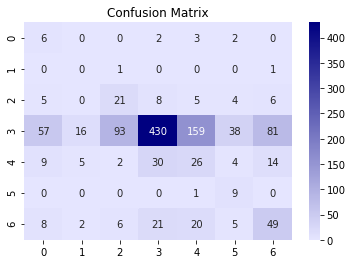

In [106]:
from sklearn.metrics import confusion_matrix
import pylab as plt
import seaborn as sns

cm = confusion_matrix(testpredict, df_test['Y'])
sns.heatmap(cm, cmap=sns.light_palette(
    "navy", as_cmap=True), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [107]:
%%time
last_data_features = pipeline.transform(df_last['utterance'].values)
last_data_features = last_data_features.toarray()
lasts = pd.DataFrame(last_data_features, columns=vocab)
lastpredict = forest.predict(lasts.values)

CPU times: user 557 ms, sys: 122 ms, total: 679 ms
Wall time: 460 ms


In [108]:
pd.Series(lastpredict).value_counts()

neutral        2536
surprise        342
non-neutral     200
joy             153
sadness          28
anger            25
disgust          12
dtype: int64

In [109]:
sample['Predicted'] = lastpredict
sample.to_csv("/kaggle/working/result2randomforest.csv", sep=",", index=False)